<a href="https://colab.research.google.com/github/TimeCostsLives/fake-doctors/blob/master/LSTM_WaterLevelPrediction_%EC%8B%9C%EA%B0%84%EB%B3%84_%EC%98%88%EC%B8%A1_%ED%86%B5%ED%95%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/gdrive/MyDrive/')

ValueError: ignored

In [24]:
!git init

Initialized empty Git repository in /content/.git/


In [ ]:
!git commit -m 'whole data and model'

In [4]:
!git clone https://github.com/MovmntR/with-jaewon.git '/gdrive/My Drive/Colab Notebooks/with_jaewon'

Cloning into '/gdrive/My Drive/Colab Notebooks/with_jaewon'...


# 0. Preparing

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten, Embedding
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/with_jaewon/input_1hr.csv', sep=',')
df_3h = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/with_jaewon/input_3hr.csv', sep=',')
df_6h = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/with_jaewon/input_6hr.csv', sep=',')

df.head()

,time,HGR,AMC_5d_1h,HGR_1h,HSJ_1h
0,06-6-1 6:00,0.55,0.0,0.55,0.55
1,06-6-1 6:10,0.55,0.0,0.55,0.55
2,06-6-1 6:20,0.55,0.0,0.55,0.55
3,06-6-1 6:30,0.55,0.0,0.55,0.55
4,06-6-1 6:40,0.55,0.0,0.55,0.55


In [ ]:
print(df.shape)

(263484, 5)


In [ ]:
df['time'] = np.linspace(0, 1, 263484)
df_3h['time'] = np.linspace(0, 1, 263484)
df_6h['time'] = np.linspace(0, 1, 263484)

df.head()

,time,HGR,AMC_5d_1h,HGR_1h,HSJ_1h
0,0.000000,0.55,0.0,0.55,0.55
1,0.000004,0.55,0.0,0.55,0.55
2,0.000008,0.55,0.0,0.55,0.55
3,0.000011,0.55,0.0,0.55,0.55
4,0.000015,0.55,0.0,0.55,0.55


In [ ]:
# 스케일링

scaler = MinMaxScaler()
scale_cols = ['time','HGR','AMC_5d_1h', 'HGR_1h', 'HSJ_1h']
df_scaled = scaler.fit_transform(df[scale_cols])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

NameError: ignored

In [ ]:
scale_cols_3h = ['time','HGR','AMC_5d_3h', 'HGR_3h', 'HSJ_3h']
df_scaled_3h = scaler.fit_transform(df_3h[scale_cols_3h])
df_scaled_3h = pd.DataFrame(df_scaled_3h)
df_scaled_3h.columns = scale_cols_3h

In [ ]:
scale_cols_6h = ['time','HGR','AMC_5d_6h', 'HGR_6h', 'HSJ_6h']
df_scaled_6h = scaler.fit_transform(df_6h[scale_cols_6h])
df_scaled_6h = pd.DataFrame(df_scaled_6h)
df_scaled_6h.columns = scale_cols_6h

df_scaled_6h.head()

(263484, 5)

In [ ]:
# X - y 구분

X_df = df_scaled.drop(['HGR'], axis=1)
y_df = df_scaled[['HGR']]

X_df_3h = df_scaled_3h.drop(['HGR'], axis=1)
y_df_3h = df_scaled_3h[['HGR']]

X_df_6h = df_scaled_6h.drop(['HGR'], axis=1)
y_df_6h = df_scaled_6h[['HGR']]

In [ ]:
# 시리얼 데이터셋

def make_dataset(data_set, label_set, window_size=1):
  X_list = []
  y_list = []
  for i in range(len(data_set)-window_size):
    X_list.append(np.array(data_set.iloc[i:i+window_size]))
    y_list.append(np.array(label_set.iloc[i+window_size]))
  return np.array(X_list), np.array(y_list)

X_data, y_data = make_dataset(X_df, y_df, 6)
X_data_3h, y_data_3h = make_dataset(X_df, y_df, 6)
X_data_6h, y_data_6h = make_dataset(X_df_6h, y_df_6h, 6)

X_data_6h.shape, y_data_6h.shape

((263478, 6, 4), (263478, 1))

In [ ]:
# 데이터셋 구분

row = 210780

X_train = X_data[:row]
X_test = X_data[row:]
y_train = y_data[:row]
y_test = y_data[row:]

X_train_3h = X_data_3h[:row]
X_test_3h = X_data_3h[row:]
y_train_3h = y_data_3h[:row]
y_test_3h = y_data_3h[row:]

X_train_6h = X_data_6h[:row]
X_test_6h = X_data_6h[row:]
y_train_6h = y_data_6h[:row]
y_test_6h = y_data_6h[row:]

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)
X_train_3h, X_valid_3h, y_train_3h, y_valid_3h = train_test_split(X_train_3h, y_train_3h, test_size=0.2)
X_train_6h, X_valid_6h, y_train_6h, y_valid_6h = train_test_split(X_train_6h, y_train_6h, test_size=0.2)

X_train_6h.shape, y_train_6h.shape, X_valid_6h.shape, y_valid_6h.shape, X_test_6h.shape, y_test_6h.shape

((168624, 6, 4),
 (168624, 1),
 (42156, 6, 4),
 (42156, 1),
 (52698, 6, 4),
 (52698, 1))

# 1-1. Trainning : LSTM

In [ ]:
rm -rf ./logs/

In [ ]:
EP = 10       # Epochs
BS = 32       # Batch_size
LR = 0.00001  # Learning_Rate


In [ ]:
# LSTM 모델

model = Sequential()
model.add(LSTM(4, input_shape=(6,4)))
model.add(Dense(1))

checkpoint_dir = os.path.join('/content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_1h/cp.ckpt')
model_check = ModelCheckpoint(filepath=checkpoint_dir, monitor='val_loss', mode='auto', verbose=1, save_best_only=True)

model.compile(optimizer=optimizers.Adam(learning_rate=LR), loss='mean_squared_error')
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=EP, batch_size=BS, callbacks=model_check)

Epoch 1/10
5270/5270 [==============================] - 20s 3ms/step - loss: 0.0061 - val_loss: 0.0038

Epoch 00001: val_loss improved from inf to 0.00382, saving model to /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_1h/cp.ckpt


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_1h/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_1h/cp.ckpt/assets


Epoch 2/10
5270/5270 [==============================] - 17s 3ms/step - loss: 0.0034 - val_loss: 0.0022

Epoch 00002: val_loss improved from 0.00382 to 0.00221, saving model to /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_1h/cp.ckpt


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_1h/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_1h/cp.ckpt/assets


Epoch 3/10
5270/5270 [==============================] - 17s 3ms/step - loss: 0.0020 - val_loss: 0.0012

Epoch 00003: val_loss improved from 0.00221 to 0.00125, saving model to /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_1h/cp.ckpt


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_1h/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_1h/cp.ckpt/assets


Epoch 4/10
5270/5270 [==============================] - 17s 3ms/step - loss: 0.0011 - val_loss: 7.0926e-04

Epoch 00004: val_loss improved from 0.00125 to 0.00071, saving model to /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_1h/cp.ckpt


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_1h/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_1h/cp.ckpt/assets


Epoch 5/10
5270/5270 [==============================] - 17s 3ms/step - loss: 6.1832e-04 - val_loss: 4.0028e-04

Epoch 00005: val_loss improved from 0.00071 to 0.00040, saving model to /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_1h/cp.ckpt


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_1h/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_1h/cp.ckpt/assets


Epoch 6/10
5270/5270 [==============================] - 17s 3ms/step - loss: 3.4586e-04 - val_loss: 2.2259e-04

Epoch 00006: val_loss improved from 0.00040 to 0.00022, saving model to /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_1h/cp.ckpt


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_1h/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_1h/cp.ckpt/assets


Epoch 7/10
5270/5270 [==============================] - 17s 3ms/step - loss: 1.9266e-04 - val_loss: 1.3301e-04

Epoch 00007: val_loss improved from 0.00022 to 0.00013, saving model to /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_1h/cp.ckpt


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_1h/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_1h/cp.ckpt/assets


Epoch 8/10
5270/5270 [==============================] - 17s 3ms/step - loss: 1.2266e-04 - val_loss: 9.7692e-05

Epoch 00008: val_loss improved from 0.00013 to 0.00010, saving model to /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_1h/cp.ckpt


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_1h/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_1h/cp.ckpt/assets


Epoch 9/10
5270/5270 [==============================] - 17s 3ms/step - loss: 9.5103e-05 - val_loss: 8.6393e-05

Epoch 00009: val_loss improved from 0.00010 to 0.00009, saving model to /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_1h/cp.ckpt


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_1h/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_1h/cp.ckpt/assets


Epoch 10/10
5270/5270 [==============================] - 17s 3ms/step - loss: 8.8589e-05 - val_loss: 8.2395e-05

Epoch 00010: val_loss improved from 0.00009 to 0.00008, saving model to /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_1h/cp.ckpt


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_1h/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_1h/cp.ckpt/assets


In [ ]:
rm -rf ./logs/

In [ ]:
model_3h = Sequential()
model_3h.add(LSTM(4, input_shape=(6,4)))
model_3h.add(Dense(1))

checkpoint_dir = os.path.join('/content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_3h/cp.ckpt')
model_check = ModelCheckpoint(filepath=checkpoint_dir, monitor='val_loss', mode='auto', verbose=1, save_best_only=True)

model_3h.compile(optimizer=optimizers.Adam(learning_rate=LR), loss='mean_squared_error')
history_3h = model_3h.fit(X_train_3h, y_train_3h, validation_data=(X_valid_3h, y_valid_3h), epochs=EP, batch_size=BS, callbacks=model_check)

Epoch 1/10
5270/5270 [==============================] - 19s 3ms/step - loss: 0.0095 - val_loss: 0.0066

Epoch 00001: val_loss improved from inf to 0.00656, saving model to /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_3h/cp.ckpt


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_3h/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_3h/cp.ckpt/assets


Epoch 2/10
5270/5270 [==============================] - 18s 3ms/step - loss: 0.0058 - val_loss: 0.0042

Epoch 00002: val_loss improved from 0.00656 to 0.00417, saving model to /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_3h/cp.ckpt


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_3h/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_3h/cp.ckpt/assets


Epoch 3/10
5270/5270 [==============================] - 18s 3ms/step - loss: 0.0036 - val_loss: 0.0023

Epoch 00003: val_loss improved from 0.00417 to 0.00228, saving model to /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_3h/cp.ckpt


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_3h/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_3h/cp.ckpt/assets


Epoch 4/10
5270/5270 [==============================] - 18s 3ms/step - loss: 0.0018 - val_loss: 9.1347e-04

Epoch 00004: val_loss improved from 0.00228 to 0.00091, saving model to /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_3h/cp.ckpt


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_3h/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_3h/cp.ckpt/assets


Epoch 5/10
5270/5270 [==============================] - 17s 3ms/step - loss: 7.3890e-04 - val_loss: 4.3249e-04

Epoch 00005: val_loss improved from 0.00091 to 0.00043, saving model to /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_3h/cp.ckpt


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_3h/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_3h/cp.ckpt/assets


Epoch 6/10
5270/5270 [==============================] - 17s 3ms/step - loss: 3.7154e-04 - val_loss: 2.6075e-04

Epoch 00006: val_loss improved from 0.00043 to 0.00026, saving model to /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_3h/cp.ckpt


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_3h/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_3h/cp.ckpt/assets


Epoch 7/10
5270/5270 [==============================] - 17s 3ms/step - loss: 2.3402e-04 - val_loss: 1.8133e-04

Epoch 00007: val_loss improved from 0.00026 to 0.00018, saving model to /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_3h/cp.ckpt


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_3h/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_3h/cp.ckpt/assets


Epoch 8/10
5270/5270 [==============================] - 18s 3ms/step - loss: 1.6896e-04 - val_loss: 1.5130e-04

Epoch 00008: val_loss improved from 0.00018 to 0.00015, saving model to /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_3h/cp.ckpt


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_3h/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_3h/cp.ckpt/assets


Epoch 9/10
5270/5270 [==============================] - 18s 3ms/step - loss: 1.4526e-04 - val_loss: 1.3975e-04

Epoch 00009: val_loss improved from 0.00015 to 0.00014, saving model to /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_3h/cp.ckpt


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_3h/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_3h/cp.ckpt/assets


Epoch 10/10
5270/5270 [==============================] - 19s 4ms/step - loss: 1.3546e-04 - val_loss: 1.3307e-04

Epoch 00010: val_loss improved from 0.00014 to 0.00013, saving model to /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_3h/cp.ckpt


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_3h/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_3h/cp.ckpt/assets


In [ ]:
rm -rf ./logs/

In [ ]:
model_6h = Sequential()
model_6h.add(LSTM(4, input_shape=(6,4)))
model_6h.add(Dense(1))

checkpoint_dir = os.path.join('/content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_6h/cp.ckpt')
model_check = ModelCheckpoint(filepath=checkpoint_dir, monitor='val_loss', mode='auto', verbose=1, save_best_only=True)

model_6h.compile(optimizer=optimizers.Adam(learning_rate=LR), loss='mean_squared_error')
history_6h = model_6h.fit(X_train_6h, y_train_6h, validation_data=(X_valid_6h, y_valid_6h), epochs=EP, batch_size=BS, callbacks=model_check)

Epoch 1/10
5270/5270 [==============================] - 20s 4ms/step - loss: 0.0424 - val_loss: 0.0094

Epoch 00001: val_loss improved from inf to 0.00937, saving model to /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_6h/cp.ckpt


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_6h/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_6h/cp.ckpt/assets


Epoch 2/10
5270/5270 [==============================] - 18s 3ms/step - loss: 0.0072 - val_loss: 0.0044

Epoch 00002: val_loss improved from 0.00937 to 0.00435, saving model to /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_6h/cp.ckpt


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_6h/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_6h/cp.ckpt/assets


Epoch 3/10
5270/5270 [==============================] - 17s 3ms/step - loss: 0.0037 - val_loss: 0.0020

Epoch 00003: val_loss improved from 0.00435 to 0.00204, saving model to /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_6h/cp.ckpt


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_6h/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_6h/cp.ckpt/assets


Epoch 4/10
5270/5270 [==============================] - 17s 3ms/step - loss: 0.0017 - val_loss: 8.4222e-04

Epoch 00004: val_loss improved from 0.00204 to 0.00084, saving model to /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_6h/cp.ckpt


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_6h/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_6h/cp.ckpt/assets


Epoch 5/10
5270/5270 [==============================] - 17s 3ms/step - loss: 7.4093e-04 - val_loss: 6.2872e-04

Epoch 00005: val_loss improved from 0.00084 to 0.00063, saving model to /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_6h/cp.ckpt


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_6h/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_6h/cp.ckpt/assets


Epoch 6/10
5270/5270 [==============================] - 17s 3ms/step - loss: 6.5983e-04 - val_loss: 5.8987e-04

Epoch 00006: val_loss improved from 0.00063 to 0.00059, saving model to /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_6h/cp.ckpt


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_6h/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_6h/cp.ckpt/assets


Epoch 7/10
5270/5270 [==============================] - 17s 3ms/step - loss: 6.1781e-04 - val_loss: 5.6927e-04

Epoch 00007: val_loss improved from 0.00059 to 0.00057, saving model to /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_6h/cp.ckpt


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_6h/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_6h/cp.ckpt/assets


Epoch 8/10
5270/5270 [==============================] - 17s 3ms/step - loss: 6.0680e-04 - val_loss: 5.5655e-04

Epoch 00008: val_loss improved from 0.00057 to 0.00056, saving model to /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_6h/cp.ckpt


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_6h/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_6h/cp.ckpt/assets


Epoch 9/10
5270/5270 [==============================] - 17s 3ms/step - loss: 5.9707e-04 - val_loss: 5.4792e-04

Epoch 00009: val_loss improved from 0.00056 to 0.00055, saving model to /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_6h/cp.ckpt


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_6h/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_6h/cp.ckpt/assets


Epoch 10/10
5270/5270 [==============================] - 17s 3ms/step - loss: 5.7344e-04 - val_loss: 5.4128e-04

Epoch 00010: val_loss improved from 0.00055 to 0.00054, saving model to /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_6h/cp.ckpt


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_6h/cp.ckpt/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/with_jaewon/checkPoint/training_before_6h/cp.ckpt/assets


# 1-2. Evaluation

In [ ]:
# 평가

mse_test = model.evaluate(X_test, y_test, batch_size=1)
prediction = model.predict(X_test)

print('Loss of Prediction 1hr before :', mse_test)

52698/52698 [==============================] - 78s 1ms/step - loss: 0.0018
Loss of Prediction 1hr before : 0.001823520171456039


In [ ]:
mse_test_3h = model_3h.evaluate(X_test_3h, y_test_3h, batch_size=1)
prediction_3h = model_3h.predict(X_test_3h)

print('Loss of prediction 3hr before :', mse_test_3h)

52698/52698 [==============================] - 78s 1ms/step - loss: 0.0027
Loss of prediction 3hr before : 0.0027062685694545507


In [ ]:
mse_test_6h = model_6h.evaluate(X_test_6h, y_test_6h, batch_size=1)
prediction_6h = model_6h.predict(X_test_6h)

print('Loss of prediction 6hr before :', mse_test_6h)

52698/52698 [==============================] - 78s 1ms/step - loss: 0.0019
Loss of prediction 6hr before : 0.0018572304397821426


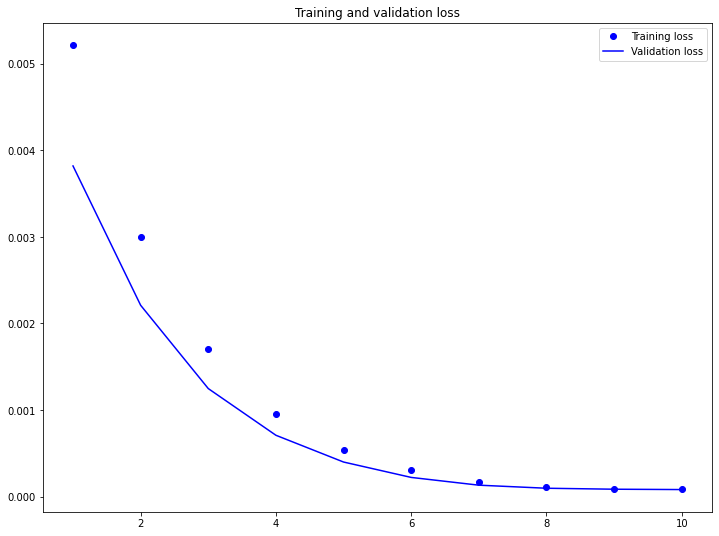

In [ ]:
# 손실 그래프

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.figure(figsize=(12, 9))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

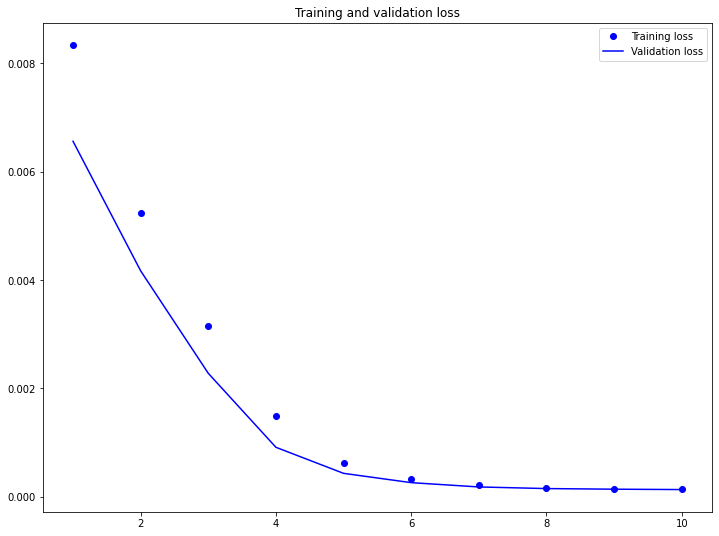

In [ ]:
loss_3h = history_3h.history['loss']
val_loss_3h = history_3h.history['val_loss']

epochs = range(1, len(loss)+1)

plt.figure(figsize=(12, 9))

plt.plot(epochs, loss_3h, 'bo', label='Training loss')
plt.plot(epochs, val_loss_3h, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

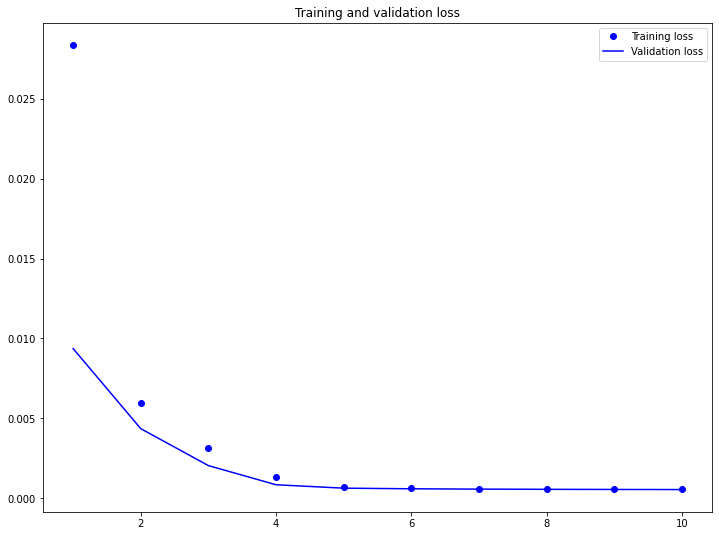

In [ ]:
loss_6h = history_6h.history['loss']
val_loss_6h = history_6h.history['val_loss']

epochs = range(1, len(loss)+1)

plt.figure(figsize=(12, 9))

plt.plot(epochs, loss_6h, 'bo', label='Training loss')
plt.plot(epochs, val_loss_6h, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 1-3. Result

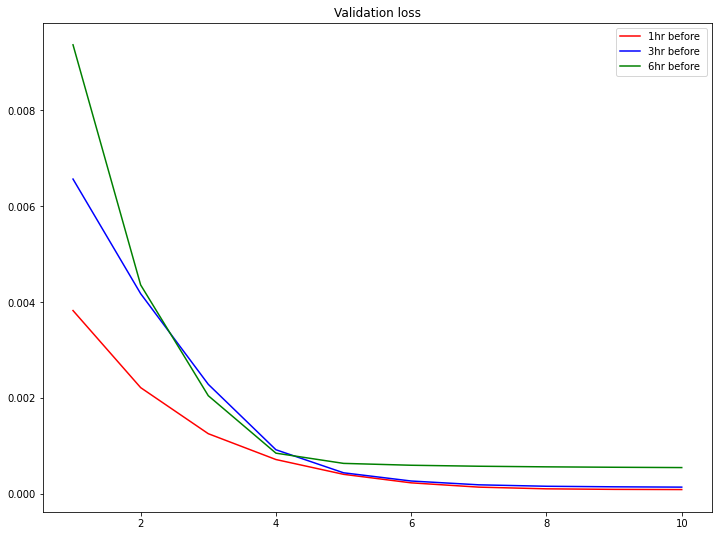

In [ ]:
plt.figure(figsize=(12, 9))

plt.plot(epochs, val_loss, 'b', label='1hr before ', color = 'red')
plt.plot(epochs, val_loss_3h, 'b', label='3hr before ', color = 'blue')
plt.plot(epochs, val_loss_6h, 'b', label='6hr before ', color = 'green')
plt.title('Validation loss')
plt.legend()

plt.show()

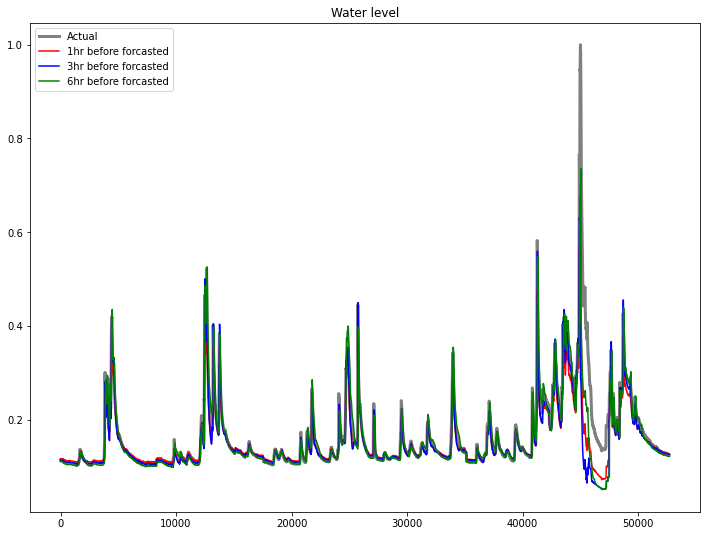

In [ ]:
plt.figure(figsize=(12,9))

plt.plot(y_test, label='Actual', color='gray', lw=3)
plt.plot(prediction, label='1hr before forcasted', color='red', ls='-')
plt.plot(prediction_3h, label='3hr before forcasted', color='blue', linestyle='-')
plt.plot(prediction_6h, label='6hr before forcasted', color='green', linestyle='-')
plt.title('Water level')
plt.legend()

plt.show()

# 2-1. Trainning : SVR

In [ ]:
scaler_svr = StandardScaler()
df_svr = scaler_svr.fit_transform(df_scaled)

X_df_svr = df_svr.drop(['HGR'], axis=1)
y_df_svr = df_svr[['HGR']]


X_train_svr = X_df_svr[:row]
y_train_svr = y_df_svr[:row]
X_test_svr = X_df_svr[row:]
y_test_svr = y_df_svr[row:]

X_train_svr, X_valid_svr, y_train_svr, y_valid_svr = train_test_split(X_train_svr, y_train_svr, test_size=0.2)

X_train_svr.shape, y_train_svr.shape, X_test_svr.shape, y_test_svr.shape

NameError: ignored

In [ ]:
model_svr = make_pipeline(StandardScaler(), SVR(C=0.01, epsilon=0.2))
history_svr = model_svr.fit(X_train_svr, y_train_svr)

NameError: ignored

# 2-2. Evaluation

In [ ]:
mse_svr = model_svr.evaluate(X_test_svr, y_test_svr, batch_size=1)
prediction = model_svr.predict(X_test_svr)

print('Loss of Prediction 1hr before :', mse_svr)

In [ ]:
loss_svr = history_svr.history['loss']
val_loss_svr = history_svr.history['val_loss']

epochs = range(1, len(loss_svr)+1)

plt.figure(figsize=(12, 9))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 2-3. Training : MLP